In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 16000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [9]:

# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        list_item.append(row[5])
        label = row[0]
        if label == '0':
          list_item.append(0)
        else:
          list_item.append(1)
        # YOUR CODE HERE
        num_sentences = num_sentences + 1
        corpus.append(list_item)




--2019-07-22 21:48:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  92.0MB/s    in 2.5s    

2019-07-22 21:48:36 (92.0 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [10]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:training_size]
test_labels = labels[:split]
training_labels = labels[split:training_size]

In [12]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

26528
1


In [13]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2019-07-22 21:50:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  91.0MB/s    in 3.6s    

2019-07-22 21:50:57 (91.0 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [14]:
print(len(embeddings_matrix))
# Expected Output
# 138859

26529


In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


W0722 21:56:30.302658 139823200667520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 21:56:30.310927 139823200667520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 21:56:33.909306 139823200667520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.o

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           2652900   
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,718,053
Trainable params: 65,153
Non-trainable params: 2,652,900
_________________________________________

<Figure size 432x288 with 0 Axes>

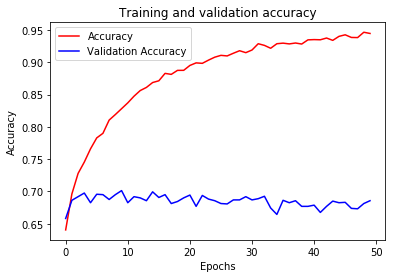

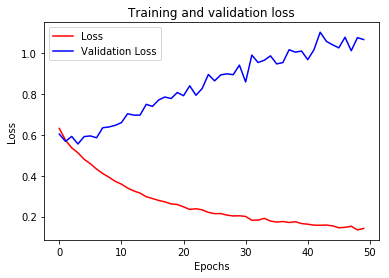

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!